# instructions

You'll want to change all of the file names and file locations. They include: 

path_to_sketches
metadata_file
dir_path 



In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import utils

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd
import pickle

In [2]:
FURNITURES = ['bed', 'bench', 'chair', 'table']
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6} # 'prob': 7} taking out probability layer for now. 
FURNITURES_label = ['bedChair_1', 'bedChair_100', 'tableBench_1', 'tableBench_100']

LAYERS_NM = ['pixel', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5', 'fc6', 'fc7']
VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3

NUM_VIEWS = 40
NUM_VIEWS_S = 20

In [3]:
def deactivate(net):
    net.eval()
    for p in net.parameters():
        p.requires_grad = False  
        
use_cuda = torch.cuda.is_available()
cuda_device = 3

vgg19 = models.vgg19(pretrained=True)#.cuda(cuda_device)
vgg19_features = deepcopy(vgg19.features)
vgg19_classifier = deepcopy(vgg19.classifier)

conv1 = nn.Sequential(*(list(vgg19.features.children())[slice(0, 5)]))
conv2 = nn.Sequential(*(list(vgg19.features.children())[slice(5, 10)]))
conv3 = nn.Sequential(*(list(vgg19.features.children())[slice(10, 19)]))
conv4 = nn.Sequential(*(list(vgg19.features.children())[slice(19, 28)]))
conv5 = nn.Sequential(*(list(vgg19.features.children())[slice(28, 37)]))
fc6 = nn.Sequential(*(list(vgg19.classifier.children())[slice(0, 2)]))
fc7 = nn.Sequential(*(list(vgg19.classifier.children())[slice(3, 5)]))
fc8 = nn.Sequential(list(vgg19.classifier.children())[-1])

if use_cuda:
    conv1.cuda(cuda_device)
    conv2.cuda(cuda_device)
    conv3.cuda(cuda_device)
    conv4.cuda(cuda_device)
    conv5.cuda(cuda_device)
    fc6.cuda(cuda_device)    
    fc7.cuda(cuda_device)    
    fc8.cuda(cuda_device)        
        
deactivate(conv1)
deactivate(conv2)
deactivate(conv3)
deactivate(conv4)
deactivate(conv5)
deactivate(fc6)
deactivate(fc7)
deactivate(fc8)

In [4]:
# get labels
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('/')[-2].split('_')[0]

def get_trial_from_path(path):
    return path.split('/')[-2].split('_')[-1]

def get_subj_from_path(path):
    return path.split('/')[-3]


def get_psketch_ID_from_path(path):
    return path.split('/')[-1].split('.')[0]


def get_trial_ID_from_path(path):
    return path.split('/')[-1].split('.')[0]




    
# extract metadata
path_to_sketches = '/home/rslee/partial_sketches'
sketch_paths = list_files(path_to_sketches)
sketch_labels = map(get_label_from_path,sketch_paths)
trialNum = map(get_trial_from_path,sketch_paths)
subj = map(get_subj_from_path,sketch_paths)
psketchID = map(get_psketch_ID_from_path, sketch_paths)

# trialID = map(get_trial_ID_from_path, sketch_paths)


# ensure that sketches are in the right order (by subject, by trial, then by partial SKetch ID) 
# note: labels are not arranged accordingly. I want this to be as close to the original metadata as possible. 
# will change to sort by labels > by trialNum if it's easy to copy/arrange the metadata 
inds_final = np.lexsort((np.asarray(psketchID).astype(int), np.asarray(trialNum).astype(int), subj))
_sketch_paths = [sketch_paths[i] for i in inds_final] 
_sketch_labels = [sketch_labels[i] for i in inds_final] 
_trialNum = [trialNum[i] for i in inds_final] 
_subj = [subj[i] for i in inds_final] 
_psketchID = [psketchID[i] for i in inds_final] 




# organize into dataframe
S = pd.DataFrame([_subj,_trialNum,_sketch_labels,_sketch_paths, _psketchID])
S = S.transpose()
S.columns = ['subj','trial','label','path','psketchID']



print 'Number of sketches: ' + str(len(sketch_paths))
print 'Number of subjects: ' + str(len(np.unique(subj)))

num_sketches = len(sketch_paths)
num_subjects = len(np.unique(subj))
num_partials = len(np.unique(psketchID))
num_trials = len(np.unique(trialNum))
num_sketches_per_subject = num_partials * num_trials

Number of sketches: 32200
Number of subjects: 35


In [5]:
# batch sketches into subjects 

sketch_paths_batched = []
for subject_i, subject in enumerate(np.unique(_subj)):
    sketch_paths_batched.append(np.asarray(_sketch_paths)[np.asarray(_subj) == subject].tolist())
    
    

In [6]:
def load_image(path, imsize=224, volatile=True, use_cuda=False):
    im = Image.open(path)
    im = im.convert('RGB')

    loader = transforms.Compose([
        transforms.Scale(imsize),
        transforms.ToTensor()])

    im = Variable(loader(im), volatile=volatile)
    im = im.unsqueeze(0)
    if use_cuda:
        im = im.cuda(cuda_device)
    return im

def sketch_generator(paths, imsize=224, use_cuda=use_cuda):
    for path in paths:
        sketch = load_image(path)
        label = get_label_from_path(path)
        yield (sketch, label)

def _flatten(x):
    return x.view(x.size(0), -1)
   
def extract_layer(x, layer_index):
    x_conv1 = conv1(x)
    if layer_index == 0:
        return _flatten(x_conv1)
    x_conv2 = conv2(x_conv1)
    if layer_index == 1:
        return _flatten(x_conv2)
    x_conv3 = conv3(x_conv2)
    if layer_index == 2:
        return _flatten(x_conv3)
    x_conv4 = conv4(x_conv3)
    if layer_index == 3:
        return _flatten(x_conv4)
    x_conv5 = conv5(x_conv4)
    x_conv5_flat = _flatten(x_conv5)
    if layer_index == 4:
        return x_conv5_flat
    x_fc6 = fc6(x_conv5_flat)
    if layer_index == 5:
        return x_fc6
    x_fc7 = fc7(x_fc6)
    if layer_index == 6:
        return x_fc7
    x_fc8 = fc8(x_fc7)
    if layer_index == 7:
        return x_fc8
    
def extract_features_and_classes(domain, num_images, layer_index):

    generator = sketch_generator(domain,imsize=224,use_cuda=use_cuda)
    # initialize image and label matrices
    Features = []
    Labels = []
    n = 0
    quit = False 

    # generate batches of imagees and labels    
    if generator:
        while True:    
            batch_size = 62
            image_batch = Variable(torch.zeros(batch_size, 3, 224, 224))
            if use_cuda:
                image_batch = image_batch.cuda(cuda_device)                
            label_batch = []   
            if n%5==0:
                print('Batch {}'.format(n + 1))            
            for b in range(batch_size):
                try:
                    image, label = generator.next()
                    image_batch[b] = image   
                    label_batch.append(label)
                except StopIteration:
                    quit = True
                    print 'stopped!'
                    break                
                
            if n == num_images//batch_size:
                image_batch = image_batch.narrow(0,0,b)
                label_batch = label_batch[:b + 1] 
            n = n + 1       

            # extract features from batch
            image_batch = extract_layer(image_batch, layer_index)                        
            image_batch = image_batch.cpu().data.numpy()

            if len(Features)==0:
                Features = image_batch
            else:
                Features = np.vstack((Features,image_batch))
            Labels.append(label_batch)

            if n == num_images//batch_size + 1:
                break
    Labels = np.array([item for sublist in Labels for item in sublist])
    return Features, Labels

In [8]:
# run extract features and build csv's per subject
# csv's shoudl be based on the original csv from sketch_data (match subj accordingly. 
for subject_i, subject in enumerate(np.unique(_subj)[-2:]):
    metadata_file = '/home/rslee/sketch_data/{:s}/{:s}_metadata.csv'.format(subject, subject)
    metadata_raw = pd.read_csv(metadata_file)
    metadata = pd.concat([metadata_raw]*num_partials,  ignore_index=True).sort_values('trial').reset_index(drop=True)
    metadata['Unnamed: 0'] = metadata.index.values

    # add in partialID 
    metadata['partial_ID'] = np.asarray(_psketchID)[np.asarray(_subj) == subject]
    
    # rearrange columns 
    cols = metadata.columns.tolist()
    cols = cols[:7] + cols[-1:] + cols[7:-1]
    metadata = metadata[cols]
    
    dir_path = '/tigress/rslee/partial_sketches/' + subject + '/'
    metadata_path_to_save = dir_path + subject + '_metadata.csv'
    pool5_path_to_save = dir_path + subject + '_pool5.p'
    
    metadata.to_csv(metadata_path_to_save)
    
    print('Extracting sketch features for subject ' + subject + '...')
    SF_i , SL = extract_features_and_classes(sketch_paths_batched[subject_i + 33], num_sketches_per_subject, 4)
    pickle.dump(SF_i, open( pool5_path_to_save, "wb" ) )
    




Extracting sketch features for subject 1207161_neurosketch...
Batch 1
Batch 6
Batch 11
stopped!
Extracting sketch features for subject 1207162_neurosketch...
Batch 1
Batch 6
Batch 11
stopped!


In [17]:
def load_images(paths, num_sketches):
    SP = np.empty((num_sketches, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), float)

    for p_i, p in enumerate(paths):
        img = utils.load_image(p)
        # take out the fourth dimension, alpha, which controls transparency
        img = img[:,:,:3]
        img = np.asarray(img.flatten()).reshape(1, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z)

        SP[p_i, :] = img
    
    return SP

In [18]:
# run extract features and build csv's per subject
# csv's shoudl be based on the original csv from sketch_data (match subj accordingly. 
for subject_i, subject in enumerate(np.unique(_subj)):
    metadata_file = '/home/rslee/sketch_data/{:s}/{:s}_metadata.csv'.format(subject, subject)
    metadata_raw = pd.read_csv(metadata_file)
    metadata = pd.concat([metadata_raw]*num_partials,  ignore_index=True).sort_values('trial').reset_index(drop=True)
    metadata['Unnamed: 0'] = metadata.index.values

    # add in partialID 
    metadata['partial_ID'] = np.asarray(_psketchID)[np.asarray(_subj) == subject]
    
    # rearrange columns 
    cols = metadata.columns.tolist()
    cols = cols[:7] + cols[-1:] + cols[7:-1]
    metadata = metadata[cols]
    
    dir_path = '/tigress/rslee/partial_s_mini/' + subject + '/'
    metadata_path_to_save = dir_path + subject + '_metadata.csv'
    pixel_path_to_save = dir_path + subject + '_pixel.p'
    
    metadata.to_csv(metadata_path_to_save)
    
    print('Extracting sketch features for subject ' + subject + '...')
    
    SP = load_images(sketch_paths_batched[subject_i], num_sketches_per_subject)
    pickle.dump(SP, open( pixel_path_to_save, "wb" ) )
    




Extracting sketch features for subject 0110171_neurosketch...
Extracting sketch features for subject 0118171_neurosketch...


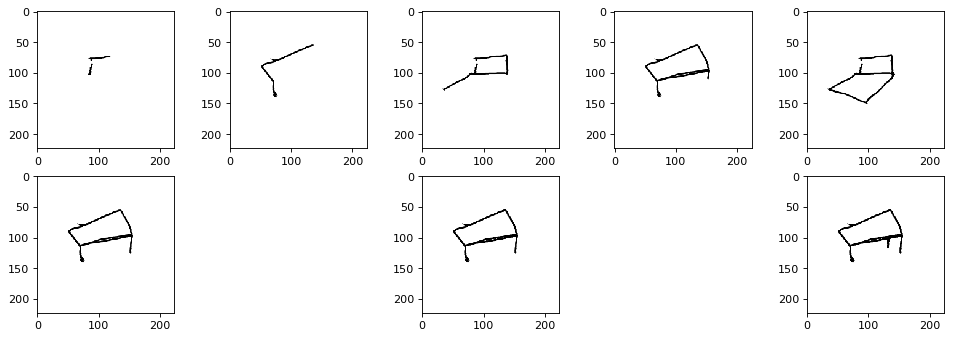

In [23]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

for subject_i, subject in enumerate(np.unique(_subj)):
    dir_path = '/tigress/rslee/partial_s_mini/' + subject + '/'
    metadata_path_to_save = dir_path + subject + '_metadata.csv'
    pixel_path_to_save = dir_path + subject + '_pixel.p'
    
    SP = pickle.load(open(pixel_path_to_save, 'rb'))
    for sketches in np.arange(5):
        plt.subplot(2, 5, (subject_i + 1) * (sketches + 1))
        img = SP[sketches,:].reshape(VGG_SIZE_X, VGG_SIZE_Y, VGG_SIZE_Z)
        plt.imshow(img)

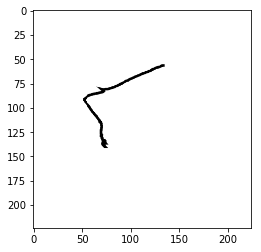

In [30]:
img = SP[0,:].reshape(VGG_SIZE_X, VGG_SIZE_Y, VGG_SIZE_Z)
plt.imshow(img)

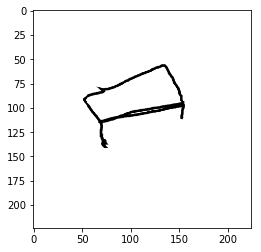

In [31]:
img = SP[1,:].reshape(VGG_SIZE_X, VGG_SIZE_Y, VGG_SIZE_Z)
plt.imshow(img)

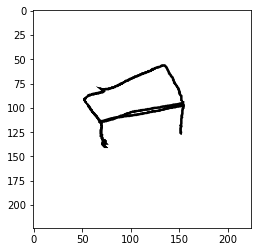

In [32]:
img = SP[2,:].reshape(VGG_SIZE_X, VGG_SIZE_Y, VGG_SIZE_Z)
plt.imshow(img)

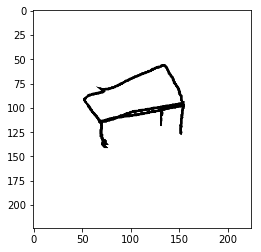

In [34]:
img = SP[4,:].reshape(VGG_SIZE_X, VGG_SIZE_Y, VGG_SIZE_Z)
plt.imshow(img)